## Import Modules

In [1]:
# Standard libraries
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import random
import re
from zipfile import ZipFile, ZIP_DEFLATED # for zipping of dataset because its too large

# ML/Deep Learning frameworks
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from nltk.translate.bleu_score import corpus_bleu

# Image libraries
from PIL import Image
import matplotlib.pyplot as plt

## Data directory

In [2]:
DATA_DIRECTORY = './drive/Othercomputers/My MacBook Air/imageCaptionGenerator/dataset/'
WORKING_DIRECTORY = './drive/Othercomputers/My MacBook Air/imageCaptionGenerator/'

## Extract image features using pre-trained VGG16 model and store in a pickle file
**NOTE**: Only run this if you do not have features.pkl **or** features.pkl.zip file

**NOTE**: The Image dataset can be very large and is hence stored locally. The directory variable should contain the path to the image folder.

[dataset](https://www.flickr.com/photos/tags/32k/)

In [ ]:
# ## load vgg16 model
# model = VGG16() 
# ## exclude last layer
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output) 
# # print(model.summary())
# 
# ## extract features from image
# features = {}
# directory = os.path.join(DATA_DIRECTORY, 'Images')
# for img_name in tqdm(os.listdir(directory)):
#   ## load image from file
#   img_file = directory + '/' + img_name
#   image = load_img(img_file, target_size=(224,224))
#   ## reshape image to numpy array
#   image = img_to_array(image)
#   ## reshape data for model (VGG16 takes in 4d array)
#   image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#   ## preprocess image for customized to vgg model
#   image = preprocess_input(image)
#   ## extract features
#   feature = model.predict(image, verbose=0) # toggle off any other display
#   ## get image ID
#   image_id = img_name.split('.')[0] # first index after splitting image name 
#   ## store features
#   features[image_id] = feature


# ## Store features in pickle to avoid re-downloading
# pickle.dump(features, open(os.path.join(WORKING_DIRECTORY, 'features.pkl'), 'wb')) # write-binary

## Load features (of images) pickle file
**Note**: This should only be done if using raw file

In [ ]:
# with open(os.path.join(WORKING_DIRECTORY, 'features.pkl'), 'rb') as f:
#   features = pickle.load(f)

## Uncomment to mount drive to use existing data stored locally

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## [**DEFAULT**] Unzip and load features pickle file

In [3]:
with ZipFile(os.path.join(WORKING_DIRECTORY, 'features.pkl.zip'), 'r') as zipObj:
   ## Extract all the contents of zip file into current directory
   print("Note that this was done in google colab, current directory is /content which is where the features.pkl file will be located.")
   ## save in current directory
   zipObj.extractall('./') 

with open('./features.pkl', 'rb') as f:
  features = pickle.load(f)

Note that this was done in google colab, current directory is /content which is where the features.pkl file will be located.


##  Then load captions file

In [4]:
with open(os.path.join(DATA_DIRECTORY, 'captions.txt'), 'r') as f:
  next(f) # ignore first line in captions.txt
  captions = f.read()

## Map image to captions

In [5]:
mapping = {}
for line in tqdm(captions.split('\n')):
  if len(line) < 2:
    continue
  ## split line by comma
  tokens = line.split(',')
  ## get id and caption
  image_id, caption = tokens[0].split('.')[0], ''.join(tokens[1:])

  ## group captions for same images tgt
  if image_id not in mapping:
    mapping[image_id] = [caption]
  else:
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
# len(mapping) # just quick check of image length

## Preprocess caption data

In [6]:
START_TAG = 'starttag'
END_TAG = 'endtag'
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      ## remove special chars
      caption = re.sub("[^A-Za-z ]", "", caption)
      ## convert to lowercase and remove trailing spaces
      caption = caption.lower().strip()
      ## remove additional white spaces between words
      caption = re.sub("[ +]", " ", caption)
      ## remove low-level information (e.g 1-char words can greatly influence result) to give more weight to important words
      caption = " ".join(word for word in caption.split(" ") if len(word) > 1)
      ## indicate start and end tag
      caption = START_TAG + " " + caption + " " + END_TAG
      ## update
      captions[i] = caption

## Testing result of preprocessing [optional]

In [7]:
print("Preprocessed: ", mapping['109202756_b97fcdc62c'])
clean(mapping)
print("Processed: ", mapping['109202756_b97fcdc62c'])

Preprocessed:  ['A woman dressed in a blue jacket and blue jeans rides a brown horse near a frozen lake and snow-covered mountain .', 'A woman in a blue jacket rides a brown pony near water .', 'A woman rides a horse near a frozen lake in the wintertime .', 'A young blond woman sitting atop a brown draft horse in the snowy mountains .', 'Woman n blue jacket sits on daft horse near a frozen lake .']
Processed:  ['starttag woman dressed in blue jacket and blue jeans rides brown horse near frozen lake and snowcovered mountain endtag', 'starttag woman in blue jacket rides brown pony near water endtag', 'starttag woman rides horse near frozen lake in the wintertime endtag', 'starttag young blond woman sitting atop brown draft horse in the snowy mountains endtag', 'starttag woman blue jacket sits on daft horse near frozen lake endtag']


## Get all captions

In [8]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
print(len(all_captions))

40455


## Tokenizing captions

In [9]:
tokenizer = Tokenizer()
## map knowledge of words to a unique number/id
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 # note index starts from 1


## Find longest length of caption

In [10]:
max_length_caption = max(len(caption.split()) for caption in all_captions)
max_length_caption

34

## Split data into Train & Test set
Standard 9:1 ratio

In [11]:
all_keys = list(mapping.keys())
split = int(len(all_keys) * 0.9)
train_data = all_keys[:split]
test_data = all_keys[split:]

## Data generator to get data in batches

In [12]:
def data_generator(train_keys, img_to_captions_map, img_features, tokenizer, max_length_caption, vocab_size, batch_size):
  X1, X2, y = [], [], []
  curr = 0
  while True:
    for key in train_keys:
      curr += 1
      captions = img_to_captions_map[key]
      for caption in captions:
        encoded = tokenizer.texts_to_sequences([caption])[0] # note: takes in a list
        ## iterative split into input and output for LSTM model
        for i in range(1, len(encoded)): # start from "starttag" tag onwards
          in_, out_ = encoded[:i], encoded[i]
          in_ = pad_sequences([in_], maxlen=max_length_caption)[0] # so that vector of correct dim to be passed as input
          # print(in_)
          # break
          out_ = to_categorical([out_], num_classes=vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_)
          y.append(out_)
      if curr == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = [], [], []
        curr = 0

## CNN-LSTM Model

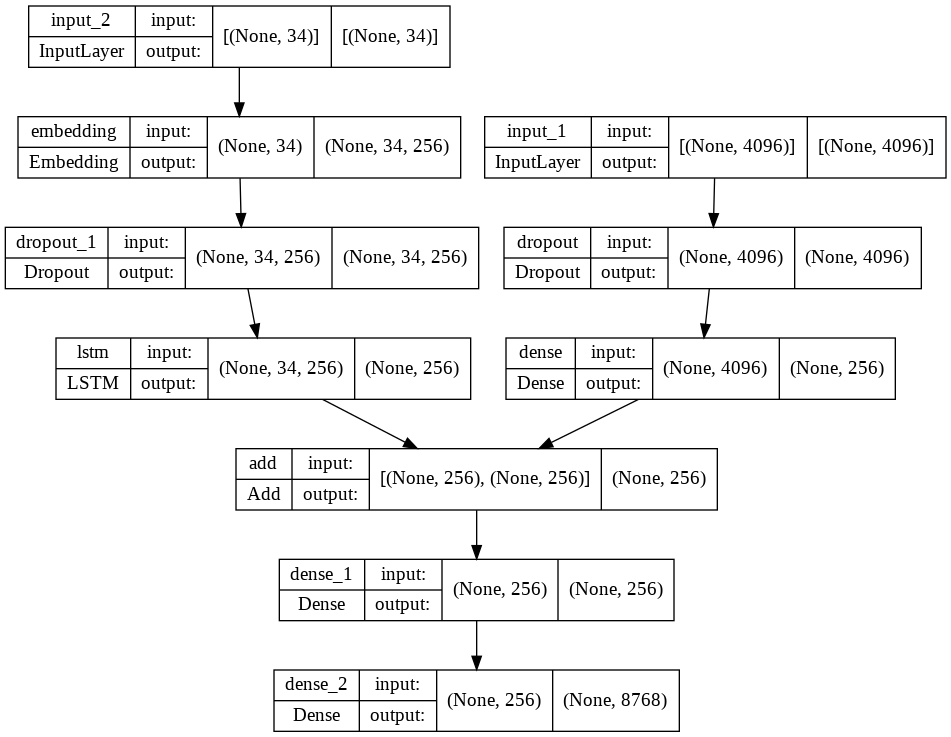

In [13]:
"""Encoder"""
## image layer
inputs1 = keras.layers.Input(shape=(4096,))
img_layer = keras.layers.Dropout(0.4)(inputs1)
img_layer = keras.layers.Dense(256, activation="relu")(img_layer)
## caption layer
inputs2 = keras.layers.Input(shape=(max_length_caption,))
cap_layer = keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
cap_layer = keras.layers.Dropout(0.4)(cap_layer)
cap_layer = keras.layers.LSTM(256)(cap_layer)

"""Decoder"""
decoder = keras.layers.add([img_layer, cap_layer])
decoder = keras.layers.Dense(256, activation="relu")(decoder)
outputs = keras.layers.Dense(vocab_size, activation="softmax")(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam")

## Visualise the model
plot_model(model, show_shapes=True)

## Train model

In [14]:
epochs = 18
batch_size = 72
steps = len(train_data) // batch_size
for i in range(epochs):
  ## avoid overfitting
  random.shuffle(train_data)
  ## create data generator
  generator = data_generator(train_data, mapping, features, tokenizer, max_length_caption, vocab_size, batch_size)
  ## fit for one epoch
  model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

101/101 [==============================] - 36s 356ms/step - loss: 2.2206


## Save model for subsequent use

In [24]:
model.save(WORKING_DIRECTORY+"my_model.h5")

## Load existing model

In [25]:
model = keras.models.load_model(WORKING_DIRECTORY+"my_model.h5")

## Generate captions for image

In [15]:
## Helper dictionary that reverses key, value pair of tokenizer.word_index
## i.e mapping of id to word
idx_to_word = {}
def convert(tokenizer):
  for word, idx in tokenizer.word_index.items():
    idx_to_word[idx] = word

convert(tokenizer)

def wordify(idx_to_word, index):
  if index in idx_to_word:
    return idx_to_word[index]
  return None

def predict_caption(model, image, tokenizer, idx_to_word, max_length_caption):
  in_text = START_TAG
  for i in range(max_length_caption): # Note: generated caption would at most be of this length
    ## encode input sequence
    input_seq = tokenizer.texts_to_sequences([in_text])[0]
    input_seq = pad_sequences([input_seq], maxlen=max_length_caption) ## Note: let it remain as a list!
    predicted_word_vector = model.predict([image, input_seq], verbose=0) # CNN-LSTM - use image and input_seq as inputs
    predicted_word_idx = np.argmax(predicted_word_vector) ## get index
    word = wordify(idx_to_word, predicted_word_idx)

    ## check if word exists
    if word is None: 
      break
    ## update display caption
    in_text += " " + word
    ## model is done generating caption
    if word == END_TAG:
      break
  return in_text

## Validation with test data
Evaluate with BLEU score

In [18]:
actual, predicted = [], []
for key in tqdm(test_data):
  captions = mapping[key]
  ## get predictions
  y_pred = predict_caption(model, features[key], tokenizer, idx_to_word, max_length_caption)
  ## split caption into words to pass into evaluator and get BLEU score
  provided_captions = [caption.split() for caption in captions]
  y_pred = y_pred.split()

  actual.append(provided_captions)
  predicted.append(y_pred)

## calculate BLEU score
## note corpus_bleu takes in as first argument a list of reference sentences
## the predicted caption will be tested against these sentences
print(f"BLEU-1: {corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))}")
print(f"BLEU-2: {corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))}")

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.563196180950216
BLEU-2: 0.34406157301559487


## Visualisation of results

In [16]:
def format_text(string):
  string = string[len(START_TAG)+1:len(string)-len(END_TAG)-1]
  return string

def generate_caption(image_file, show_original=False):
  image_id = image_file.split('.')[0]
  image_path = os.path.join(DATA_DIRECTORY, "Images", image_file)
  ## Display image
  image = Image.open(image_path)
  plt.imshow(image)
  if show_original:
    print("--------------Showing original--------------")
    captions = mapping[image_id]
    for caption in captions:
      print(format_text(caption))
    print("")
  print("--------------Showing generated--------------")
  generated = predict_caption(model, features[image_id], tokenizer, idx_to_word, max_length_caption)
  print(format_text(generated))

--------------Showing original--------------
blonde horse and blonde girl in black sweatshirt are staring at fire in barrel
girl and her horse stand by fire
girl holding horse lead behind fire
man and girl and two horses are near contained fire
two people and two horses watching fire

--------------Showing generated--------------
girl and girl in barrel stand by contained fire


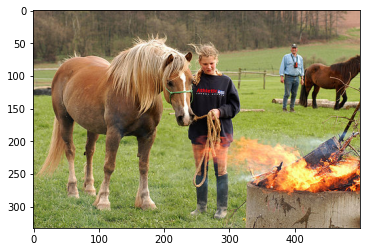

In [23]:
generate_caption('10815824_2997e03d76.jpg', True)